# OSM Contributions by OSMF Survey Region

### How do we determine which Country a mapper might be from?
There has been a decent amount of research on this question, and it's a moving target. One reasonable thought (if we ignore humanitarian or paid-editing teams), is that the Country in which a mapper makes the majority of their changesets is perhaps their home. If not their _actual home_, it is still clearly a location they posess knowledge of and continually map. Some of Pascal Neis's tools use this approach, so I recreate it here.

More specfically, this notebook is using [_regions_ instead of Countries from the 2021 OSMF Survey](https://gist.github.com/migurski/dc9d1723a7438c4502754d02ae8b6f7a#file-osmf-survey-response-regions-geojson): 

Quick Approach: Find the most occuring OSMF Region that the `min_lat`, `min_lon` point of each of a mapper's changesets falls into.

<hr>


Thanks!

[Jennings Anderson](https://jenningsanderson.com)

In [3]:
import pandas as pd; import geopandas as gpd; import seaborn as sns; import numpy as np
from shapely.geometry import Point;
import fiona, sys, json;
from matplotlib.ticker import FuncFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Now read in the changesets file from this query: 
changesets = pd.read_csv('./data/country_editing_with_homes_in_survey_regions.csv')

In [5]:
# Cast created_at to dates
changesets.created_at = changesets.created_at.apply(pd.Timestamp)

In [6]:
print("Read in {:,} changesets".format(len(changesets)))
print("First Changeset: https://openstreetmap.org/changeset/{}\nLatest Changeset: https://openstreetmap.org/changeset/{}".format(changesets.id.min(), changesets.id.max()))

Read in 19,295,286 changesets
First Changeset: https://openstreetmap.org/changeset/79071017
Latest Changeset: https://openstreetmap.org/changeset/99271735


In [7]:
# Calculate two locality and active contributions:
changesets['is_active_contributor'] = changesets.editing_days_in_last365 >= 42 #OSMF "active contributor"
changesets['is_local'] = changesets.code == changesets.most_edited_country
changesets.head(1)

,id,uid,user,created_at,num_changes,country,code,editing_days_in_last365,most_edited_country,total_edits_in_last365,changesets_in_last365,is_active_contributor,is_local
0,99271735,3703299,ct12543,2021-02-15 00:59:57,4,United States-Yes,region_17,3.0,region_17,92.0,4.0,False,True


In [8]:
# Store off a subset of unique users
all_mappers = changesets.drop_duplicates(subset='uid')[['uid','user','most_edited_country','editing_days_in_last365','total_edits_in_last365','is_active_contributor','changesets_in_last365']].reset_index(drop=True)
all_mappers.head(1)

,uid,user,most_edited_country,editing_days_in_last365,total_edits_in_last365,is_active_contributor,changesets_in_last365
0,3703299,ct12543,region_17,3.0,92.0,False,4.0


# 1. Aggregate Per Region

Counts the number of Changesets submitted per Region — as in, the Region that the changeset falls within. In this case, **local** refers to whether or not the mapper who submitted each changeset is _likely_ from that Region.

Countries/Regions like the USA are going to be over-represented with **local** changesets because of mapping teams like Amazon Logistics that almost exclusively edit in the US, so they will appear _local_.

In [25]:
gb_country = changesets.groupby(['country','is_local']).aggregate(
    {'uid':pd.Series.nunique,'id':'count','num_changes':sum}).unstack()
gb_country = gb_country.rename(columns={False: 'Non-Local', True: 'Local'}, level=1
                     ).rename(columns={'uid': 'Users', 'id': 'Changesets', 'num_changes': 'Edits'}, level=0)
gb_country.head()

Users        Changesets             Edits  \
is_local               Non-Local  Local  Non-Local   Local Non-Local   
country                                                                
-                           1476   1016      30578   25326   3479179   
Africa-anglophone-No        1026    766      14451   11225   2919839   
Africa-anglophone-Yes       8238  22122     188846  675869  26813058   
Africa-romanophone-No       2961   2411      41977   40583   8843234   
Africa-romanophone-Yes      5039   6066      84539  213397  20033019   

                                   
is_local                    Local  
country                            
-                         3207869  
Africa-anglophone-No      3019641  
Africa-anglophone-Yes   135049065  
Africa-romanophone-No     9177125  
Africa-romanophone-Yes   51673930

In [26]:
country_order = changesets.groupby('country').aggregate({'num_changes':sum,'id':'count','uid':pd.Series.nunique})
country_order = country_order.sort_values(by='id', ascending=False).reset_index()
country_order.head()

,country,num_changes,id,uid
0,United States-Yes,225153009,4140909,29562
1,Germany-Yes,58352589,1561258,33848
2,"Americas, NES-Yes",112866460,1318322,26869
3,France-Yes,42735422,963607,19901
4,Africa-anglophone-Yes,161862123,864715,30360


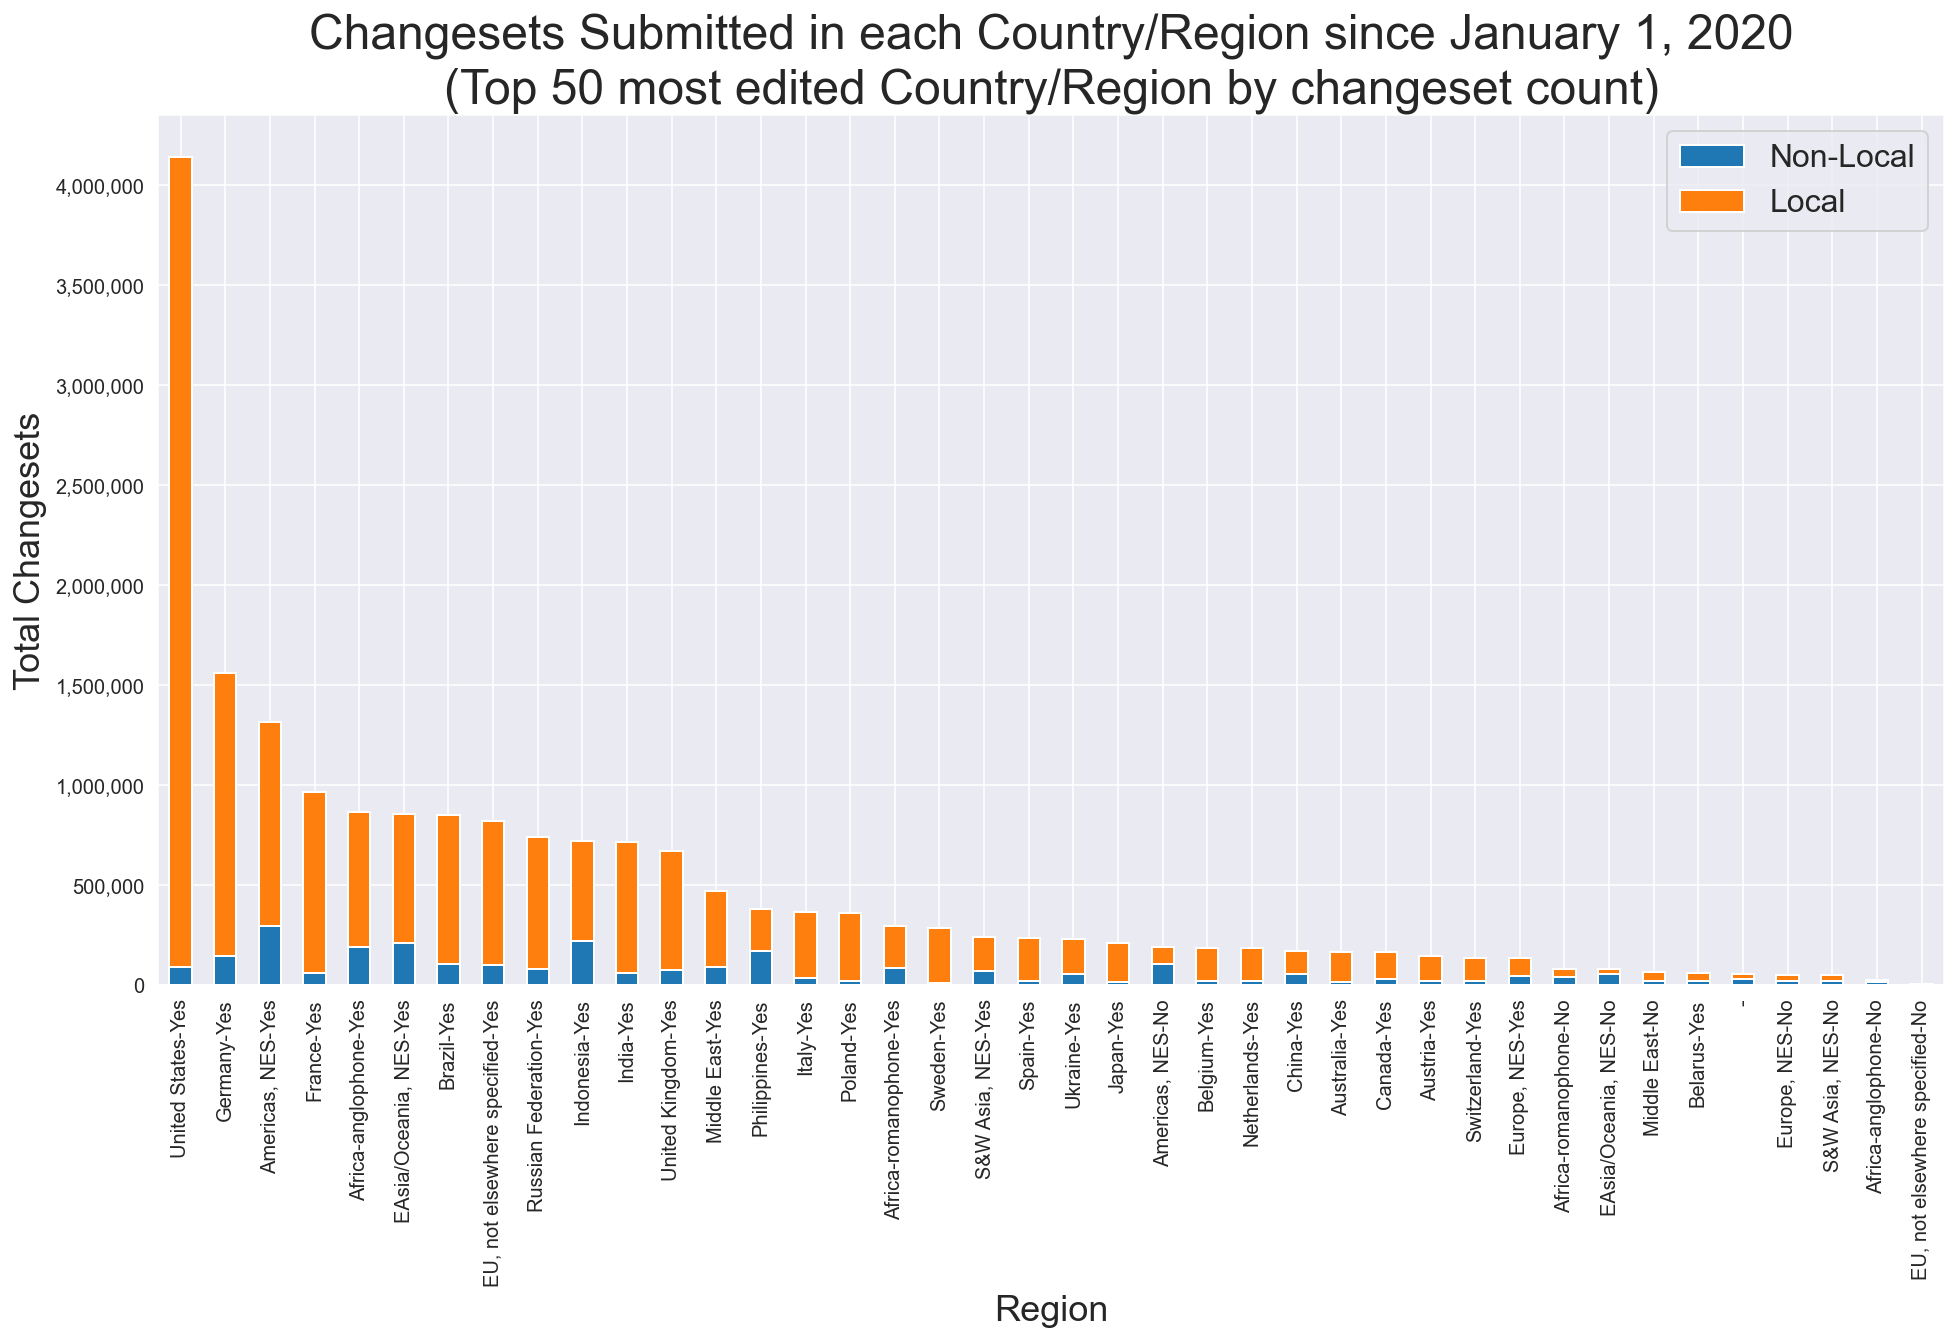

In [31]:
sns.set_style('darkgrid')
ax = gb_country.loc[country_order.head(50).country]['Changesets'].plot.bar(stacked=True, 
    figsize=(16,8))
ax.set_xlabel("Region", fontsize=18); ax.set_ylabel("Total Changesets", fontsize=18);
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_title("Changesets Submitted in each Country/Region since January 1, 2020\n(Top 50 most edited Country/Region by changeset count)", fontsize=24);
ax.legend(fontsize=16);

## By actual _edit_ count from `num_changes` field

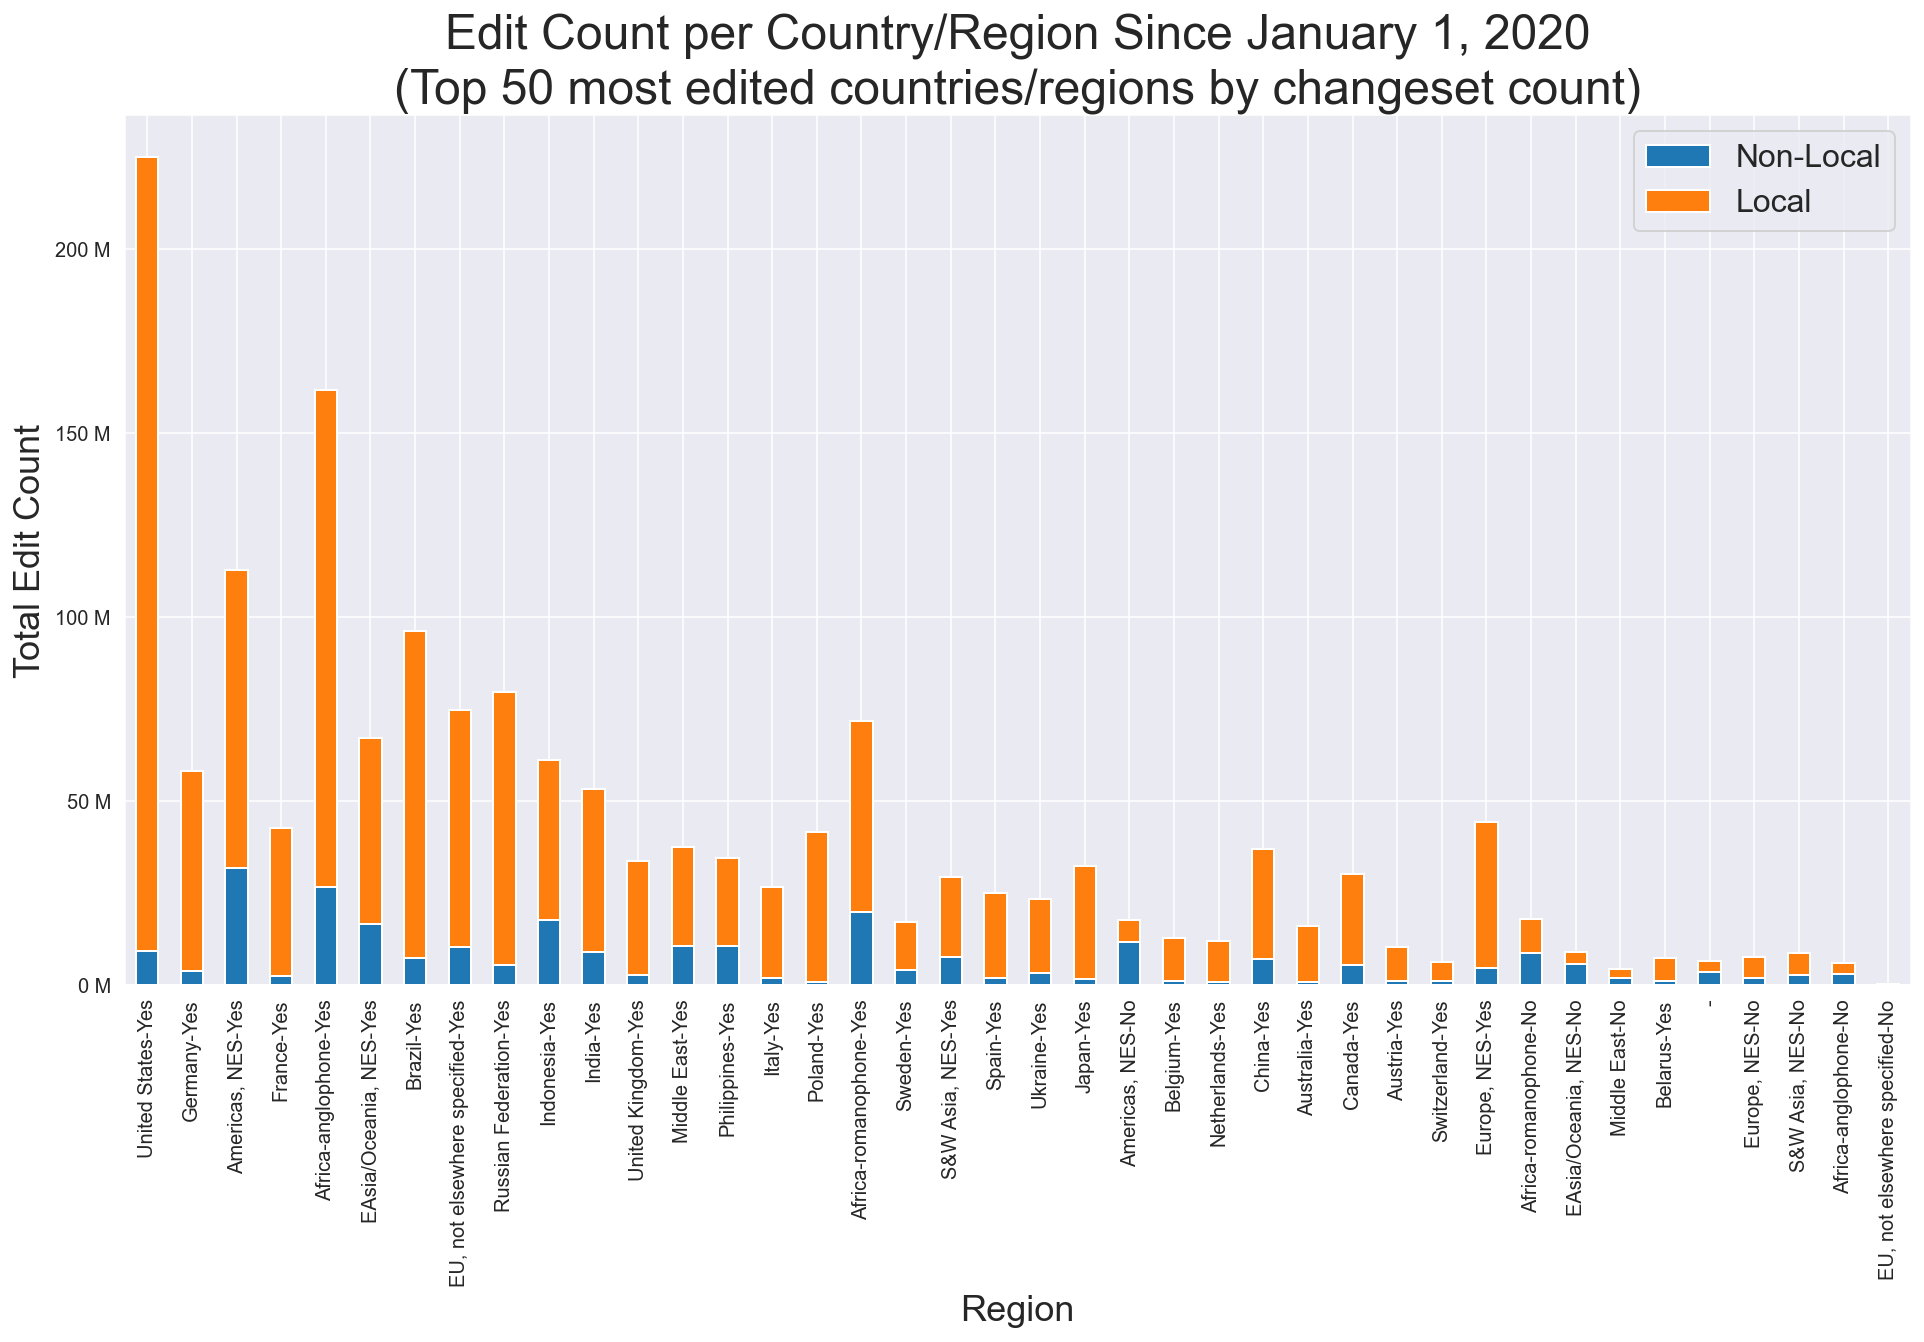

In [30]:
ax = gb_country.loc[country_order.head(50).country]['Edits'].plot.bar(stacked=True, figsize=(16,8))
ax.set_xlabel("Region", fontsize=18); ax.set_ylabel("Total Edit Count", fontsize=18);
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{} M".format(int(x/1000000))))
ax.set_title("Edit Count per Country/Region Since January 1, 2020\n(Top 50 most edited countries/regions by changeset count)", fontsize=24);
ax.legend(fontsize=16);

# Aggregated by Mapper

Breaking down the _Total Mapper_ count by local/non-local mappers per Country

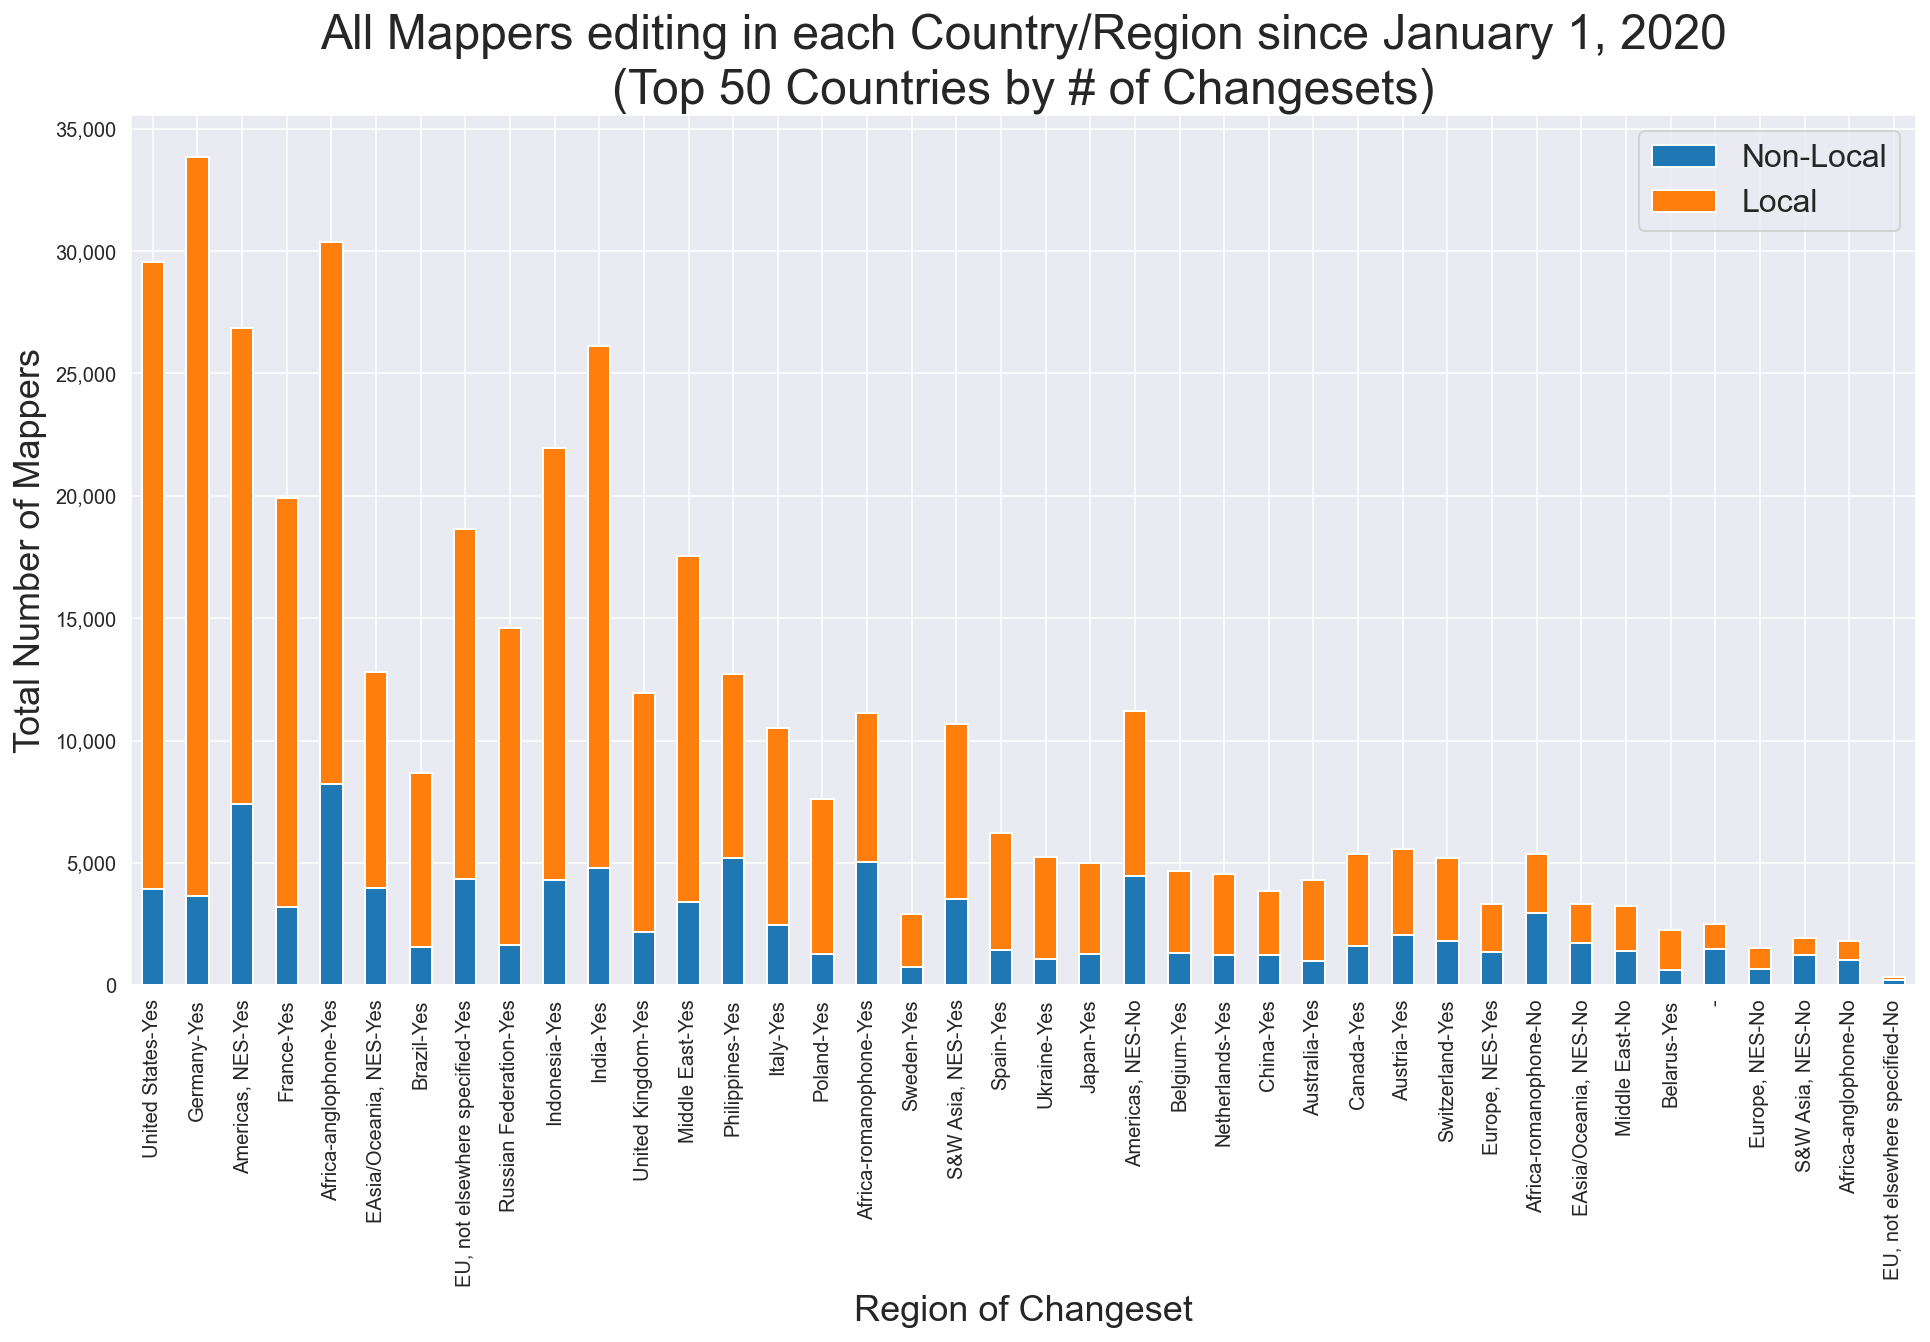

In [33]:
ax = gb_country.loc[country_order.head(50).country]['Users'].plot.bar(stacked=True, figsize=(16,8))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_xlabel("Region of Changeset", fontsize=18); ax.set_ylabel("Total Number of Mappers", fontsize=18);
ax.set_title("All Mappers editing in each Country/Region since January 1, 2020\n(Top 50 Countries by # of Changesets)", fontsize=24);
ax.legend(fontsize=16);

These numbers are massively inflated by one-time contributors in OSM. For reference, in the last year, there have been over 170k mappers who edited only on 1 day. This likely isn't really enough information to determine a "local country" so these numbers are being inflated. 

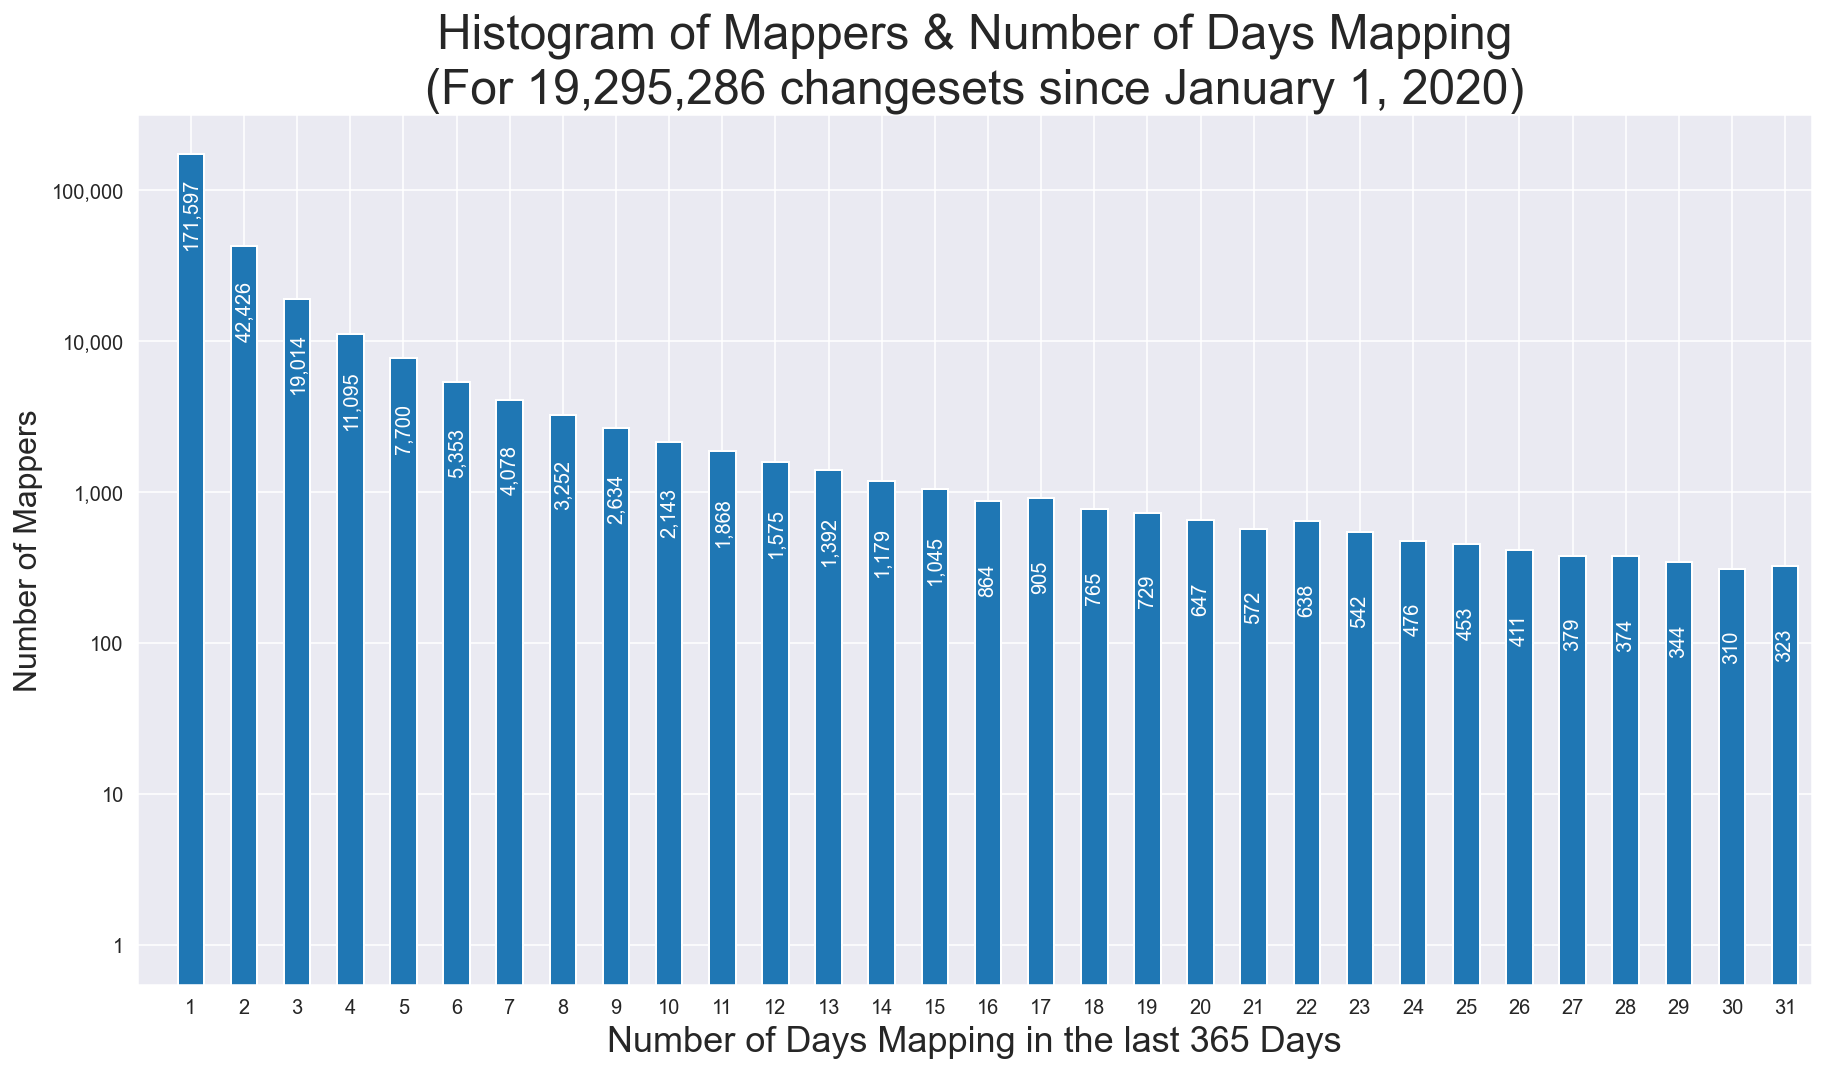

In [34]:
editing_days_hist = all_mappers.groupby('editing_days_in_last365').aggregate({'uid':'count'}).reset_index()
editing_days_hist.editing_days_in_last365 = editing_days_hist.editing_days_in_last365.astype(int)

ax = editing_days_hist.uid.plot.bar(figsize=(15,8), logy=True, legend=None);
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set_xlim(-1,30.5)
ax.set_xlabel("Number of Days Mapping in the last 365 Days", fontsize=18); 
ax.set_ylabel("Number of Mappers", fontsize=16);
ax.set_xticklabels(editing_days_hist.editing_days_in_last365, rotation=0);

for index, value in enumerate(editing_days_hist.uid.head(31)):
    ax.text(index, 0.25*value, "{:,}".format(value), rotation=90, ha='center', va='baseline', color='white')

ax.set_title("Histogram of Mappers & Number of Days Mapping\n(For {:,} changesets since January 1, 2020)".format(len(changesets)), fontsize=24);

To adjust for this, let's look only at the number of mappers active for more than 2 days: 

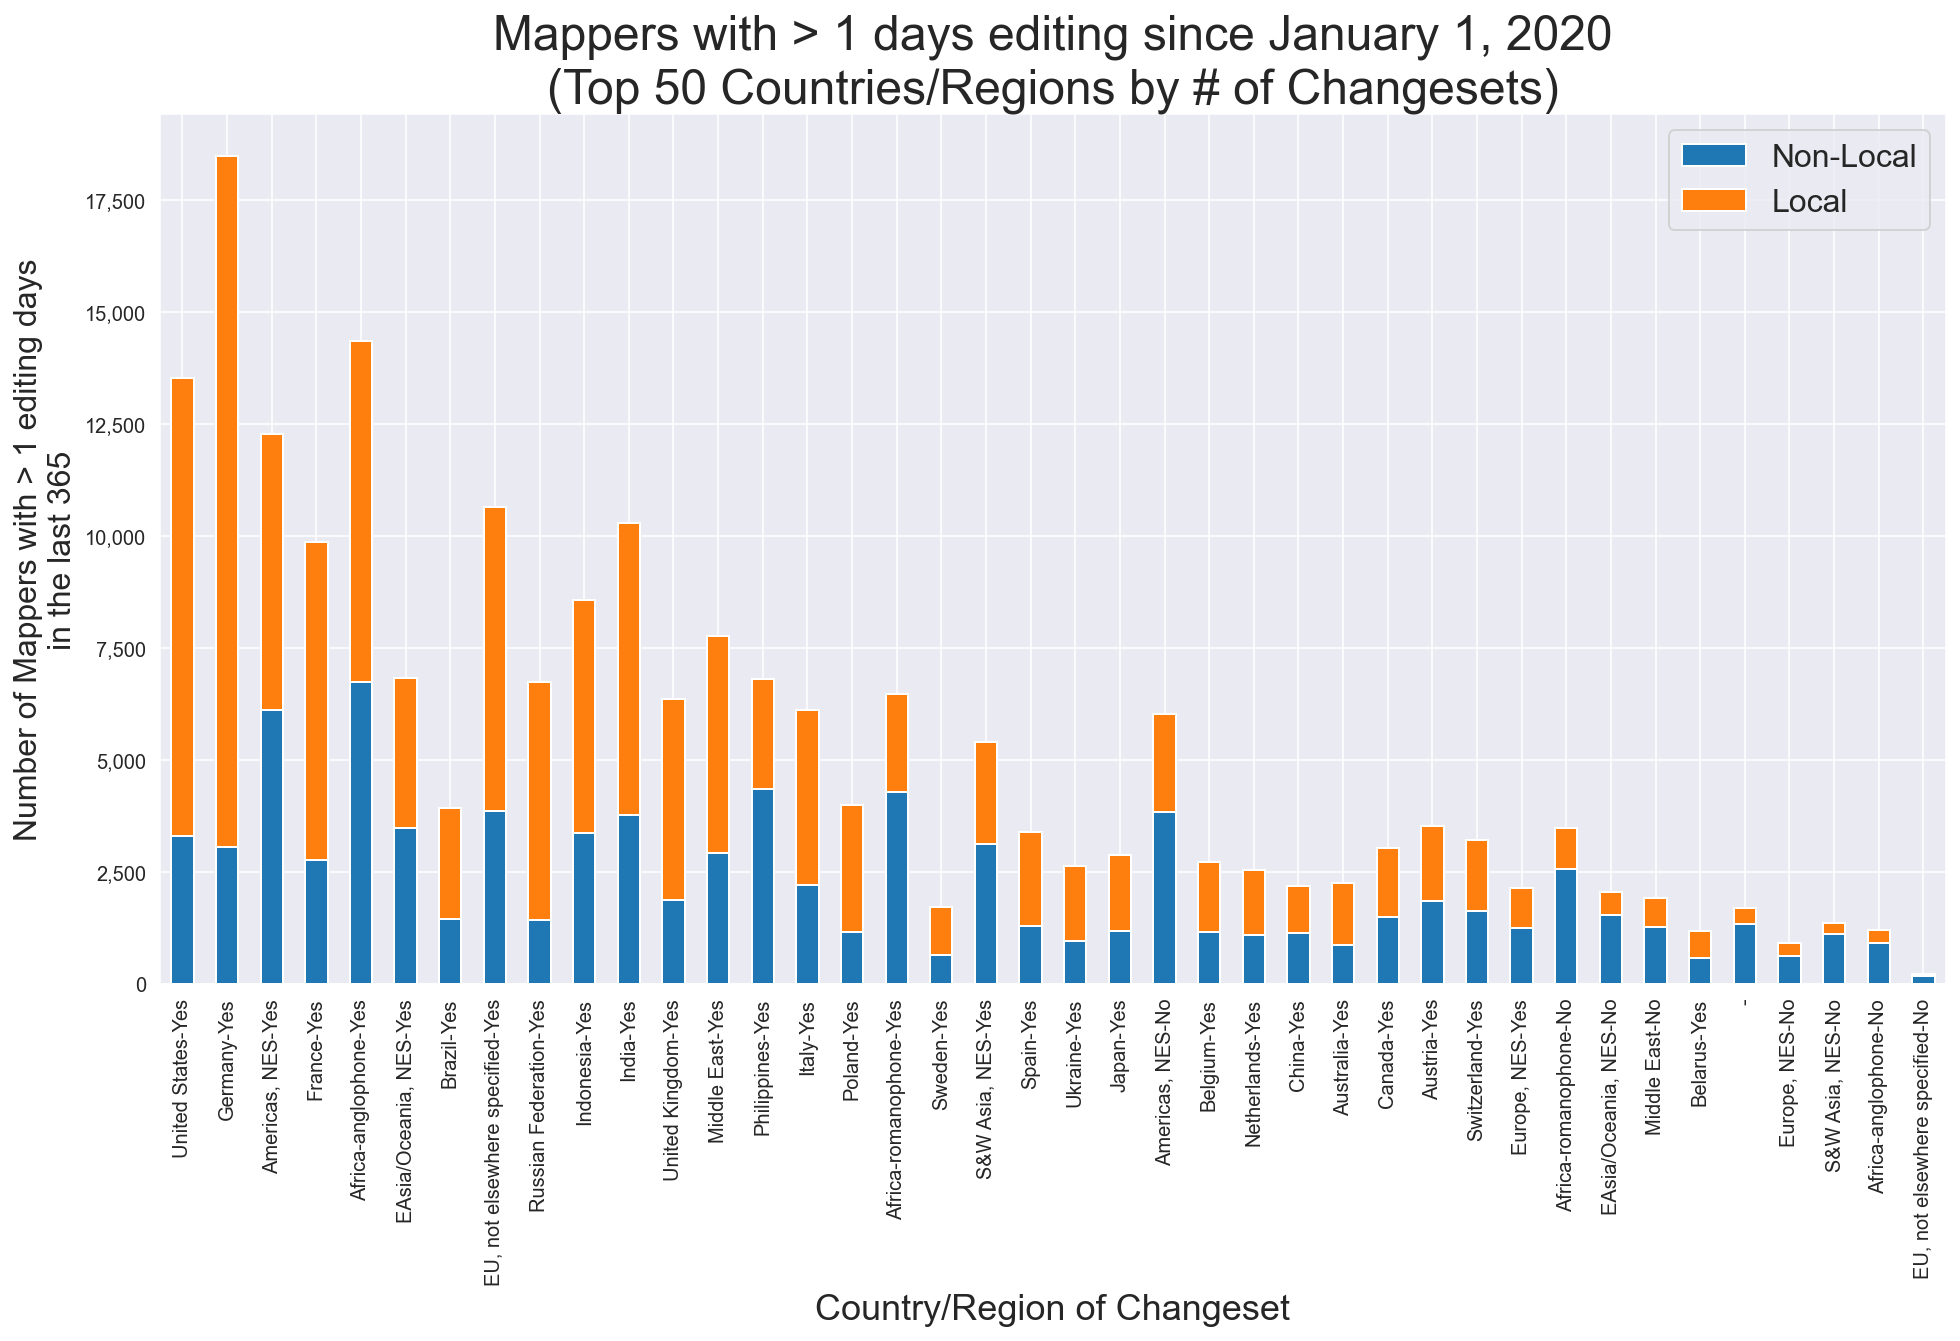

In [36]:
gb_country_gt1 = changesets[changesets.editing_days_in_last365>1].groupby(['country','is_local']).aggregate(
    {'uid':pd.Series.nunique,'id':'count','num_changes':sum}).unstack()
gb_country_gt1 = gb_country_gt1.rename(columns={False: 'Non-Local', True: 'Local'}, level=1
                     ).rename(columns={'uid': 'Users with > 1 day', 'id': 'Changesets from users with > 1 day', 'num_changes' : 'Editsfrom users with > 1 day'}, level=0)

ax = gb_country_gt1.loc[country_order.head(50).country]['Users with > 1 day'].plot.bar(stacked=True, figsize=(16,8))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
# ax.set_xlabel("Country/Region of Changeset", fontsize=18); ax.set_ylabel("Total Number of Mappers", fontsize=18);
ax.legend(fontsize=16);

# ax = gb_country_local_gt2.loc[order].plot.bar(stacked=True, figsize=(16,8))
ax.set_xlabel("Country/Region of Changeset", fontsize=18); ax.set_ylabel("Number of Mappers with > 1 editing days\nin the last 365", fontsize=16);
ax.set_title("Mappers with > 1 days editing since January 1, 2020\n(Top 50 Countries/Regions by # of Changesets)", fontsize=24);
ax.legend(fontsize=16);

Notice the change in ratios of local / non-local mappers, partially given our loose definition of "local." Overall, many of the non-local mappers disappeared in this figure (notice the major decrease on the y-axis)

# Identifying the _Active Contributors_ active per Country/Region?

In [37]:
gb_country_active = changesets.groupby(['country','is_active_contributor']).aggregate(
    {'uid':pd.Series.nunique,'id':'count','num_changes':sum}).unstack()
gb_country_active = gb_country_active.rename(columns={False: '< 42 Days', True: '>=42 Days\n("Active Contributors")'}, level=1
                     ).rename(columns={'uid': 'Users with >= 42 Days', 'id': 'Changesets from users with >= 42 days', 'num_changes': 'Edits from users with >= 42 days'}, level=0)

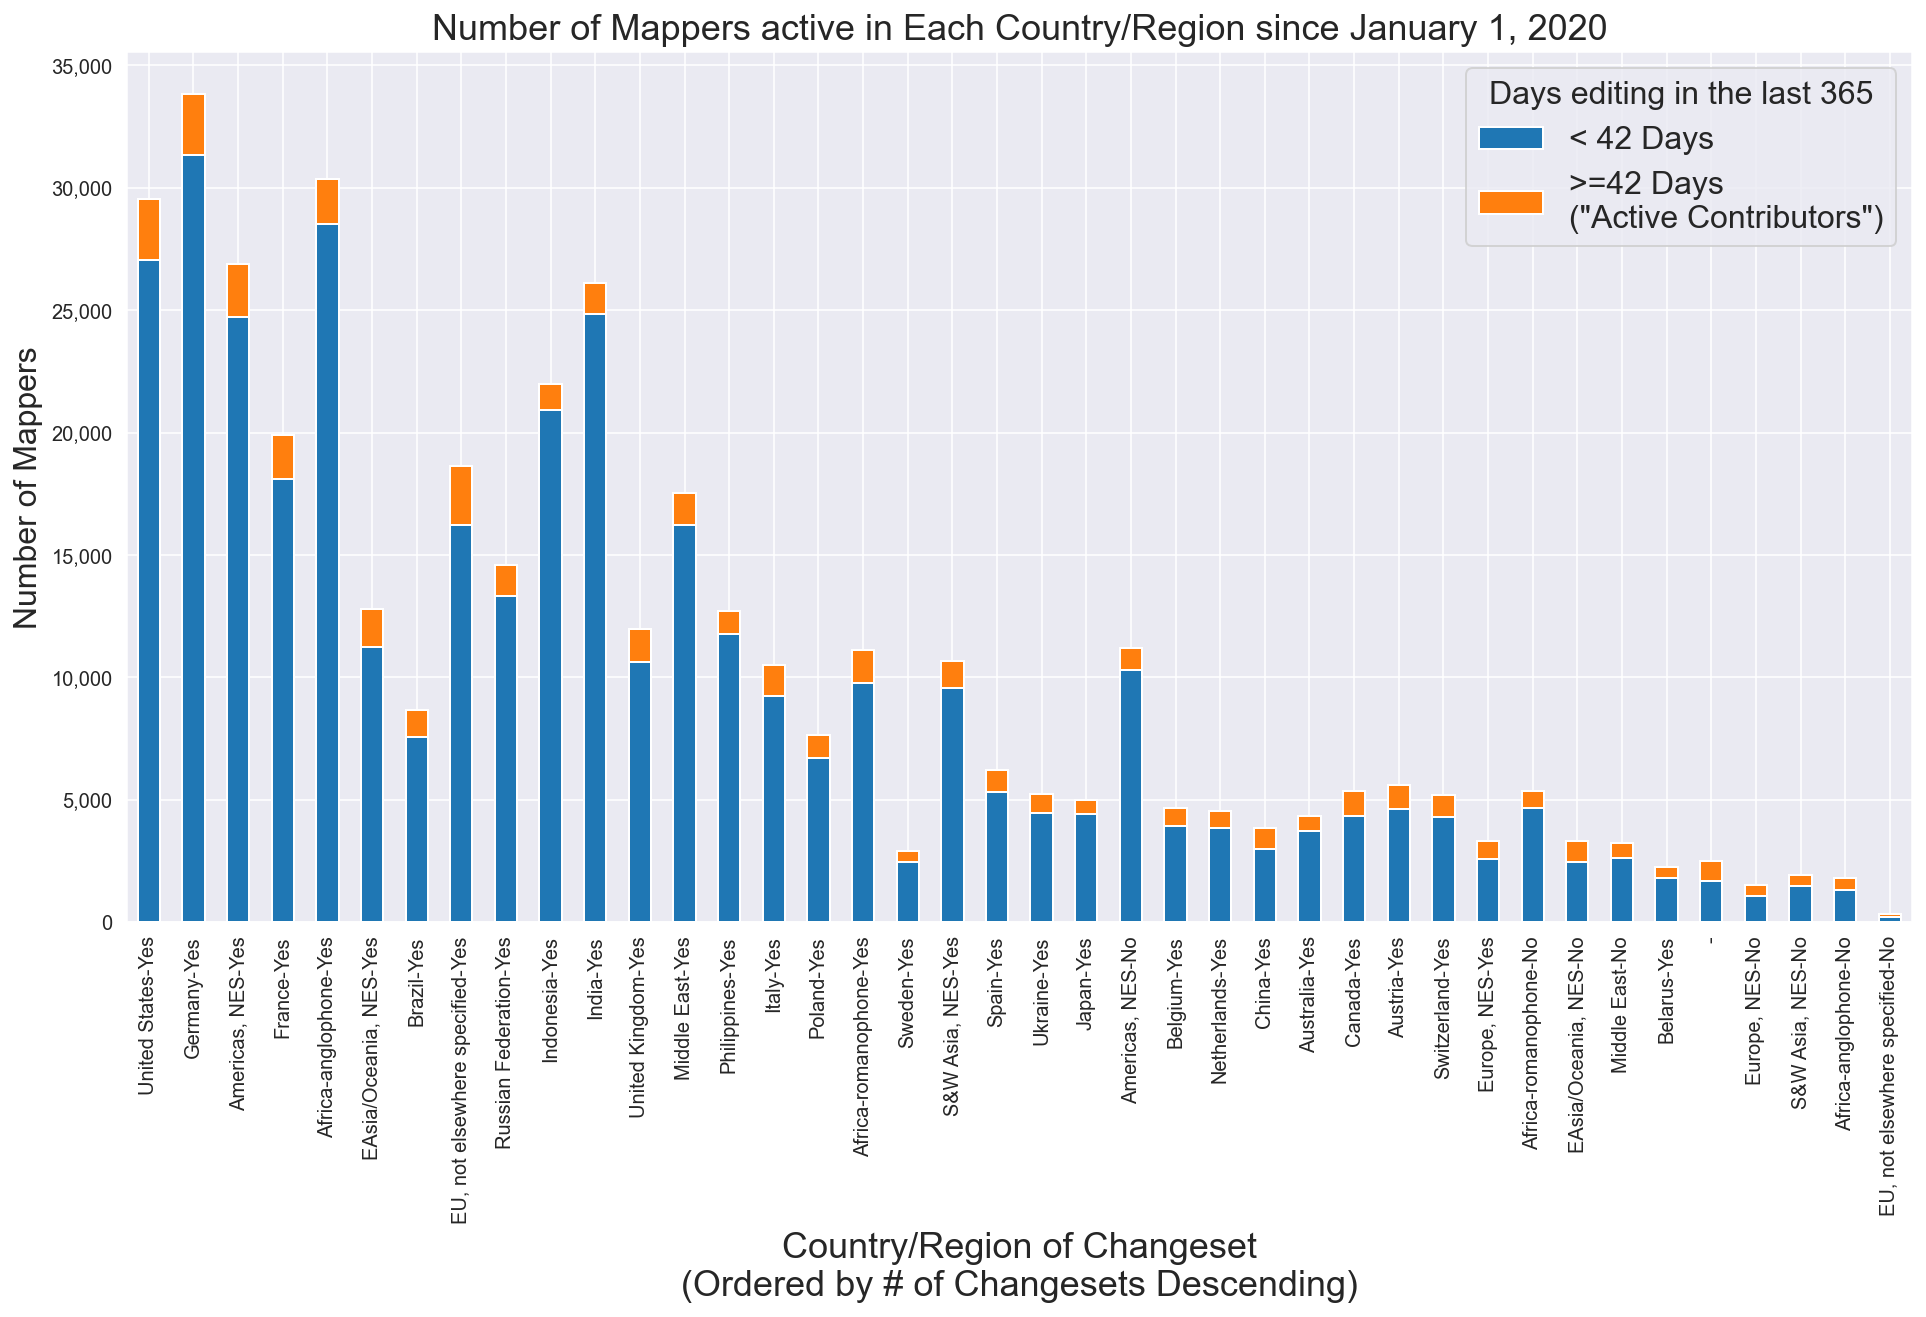

In [38]:
ax = gb_country_active.loc[country_order.head(50).country]['Users with >= 42 Days'].plot.bar(stacked=True, figsize=(16,8));
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(title="Days editing in the last 365", fontsize=16, title_fontsize=16)
ax.set_ylabel("Number of Mappers", fontsize=16); ax.set_xlabel("Country/Region of Changeset\n(Ordered by # of Changesets Descending)", fontsize=18);
ax.set_title("Number of Mappers active in Each Country/Region since January 1, 2020", fontsize=18);

## Save Per-Country Results as Table

In [40]:
as_table = gb_country.join(gb_country_gt1).join(gb_country_active)
as_table.to_csv('./data/region_editing_stats_since_2020.csv')
as_table

Users        Changesets           \
is_local                        Non-Local  Local  Non-Local    Local   
country                                                                
-                                    1476   1016      30578    25326   
Africa-anglophone-No                 1026    766      14451    11225   
Africa-anglophone-Yes                8238  22122     188846   675869   
Africa-romanophone-No                2961   2411      41977    40583   
Africa-romanophone-Yes               5039   6066      84539   213397   
Americas, NES-No                     4475   6735     106413    82696   
Americas, NES-Yes                    7405  19464     294787  1023535   
Australia-Yes                         992   3323      18574   148158   
Austria-Yes                          2043   3540      23379   122350   
Belarus-Yes                           621   1638      19331    41950   
Belgium-Yes                          1301   3376      20288   166813   
Brazil-Yes                           1568   7099     103931   748742   
Canada-Yes                           1615   3747      31492   134659   
China-Yes                            1236   2605      54773   114249   
EAsia/Oceania, NES-No                1719   1580      57144    23532   
EAsia/Oceania, NES-Yes               3974   8822     210240   644332   
EU, not elsewhere specified-No        194    143       3194     2010   
EU, not elsewhere specified-Yes      4330  14319     100662   722492   
Europe, NES-No                        664    853      20336    31909   
Europe, NES-Yes                      1355   1960      47900    86260   
France-Yes                           3194  16707      60780   902827   
Germany-Yes                          3648  30200     148481  1412777   
India-Yes                            4796  21311      62096   654820   
Indonesia-Yes                        4302  17663     223258   496174   
Italy-Yes                            2455   8060      33871   331198   
Japan-Yes                            1285   3693      18534   190283   
Middle East-No                       1399   1844      23122    41294   
Middle East-Yes                      3397  14125      89008   382943   
Netherlands-Yes                      1252   3284      20094   163630   
Philippines-Yes                      5182   7547     170414   212528   
Poland-Yes                           1259   6363      20018   342600   
Russian Federation-Yes               1636  12953      82205   657569   
S&W Asia, NES-No                     1249    661      21719    29184   
S&W Asia, NES-Yes                    3536   7143      70891   167694   
Spain-Yes                            1457   4744      23017   214064   
Sweden-Yes                            738   2161      11403   274422   
Switzerland-Yes                      1816   3367      19917   115156   
Ukraine-Yes                          1061   4164      53984   177323   
United Kingdom-Yes                   2162   9794      77504   592390   
United States-Yes                    3933  25629      89493  4051416   

                                    Edits            Users with > 1 day  \
is_local                        Non-Local      Local          Non-Local   
country                                                                   
-                                 3479179    3207869               1351   
Africa-anglophone-No              2919839    3019641                914   
Africa-anglophone-Yes            26813058  135049065               6752   
Africa-romanophone-No             8843234    9177125               2563   
Africa-romanophone-Yes           20033019   51673930               4281   
Americas, NES-No                 11790080    5864840               3855   
Americas, NES-Yes                31889110   80977350               6120   
Australia-Yes                      926562   15097688                873   
Austria-Yes                       1258557    9206645               1858   
Belarus-Yes                       10712

# Finally, Active Contributors per Country/Region?

In [19]:
all_mappers = all_mappers.rename(columns={'most_edited_country':'code'}
                  ).merge(changesets.drop_duplicates(subset='code')[['country','code']].reset_index(drop=True))
all_mappers.head()

,uid,user,code,editing_days_in_last365,total_edits_in_last365,is_active_contributor,changesets_in_last365,country
0,3703299,ct12543,region_17,3.0,92.0,False,4.0,United States-Yes
1,12254628,Wild Spike,region_17,31.0,14283.0,False,182.0,United States-Yes
2,86565,ricomundy,region_17,22.0,3836.0,False,73.0,United States-Yes
3,624084,MarksPhotoTrips,region_17,167.0,22729.0,True,562.0,United States-Yes
4,187467,Mashin,region_17,223.0,223370.0,True,1096.0,United States-Yes


In [20]:
gb_home_country_active = all_mappers.groupby(['country','is_active_contributor']).aggregate(
    {'uid':pd.Series.nunique}).unstack()

gb_home_country_active = gb_home_country_active.rename(columns={False: '< 42 Days', True: '>=42 Days\n("Active Contributors")'}, level=1
                     ).rename(columns={'uid': 'Users with >= 42 Days', 'id': 'Changesets from users with >= 42 days', 'num_changes': 'Edits from users with >= 42 days'}, level=0)

gb_home_country_active.head()

Users with >= 42 Days  \
is_active_contributor              < 42 Days   
country                                        
-                                       1212   
Africa-anglophone-No                     920   
Africa-anglophone-Yes                  23211   
Africa-romanophone-No                   2567   
Africa-romanophone-Yes                  6290   

                                                           
is_active_contributor  >=42 Days\n("Active Contributors")  
country                                                    
-                                                      23  
Africa-anglophone-No                                   21  
Africa-anglophone-Yes                                 458  
Africa-romanophone-No                                  21  
Africa-romanophone-Yes                                139

In [21]:
user_order = all_mappers.groupby('country').aggregate(
    {'uid':'count'}).sort_values(by='uid', ascending=False).reset_index().country

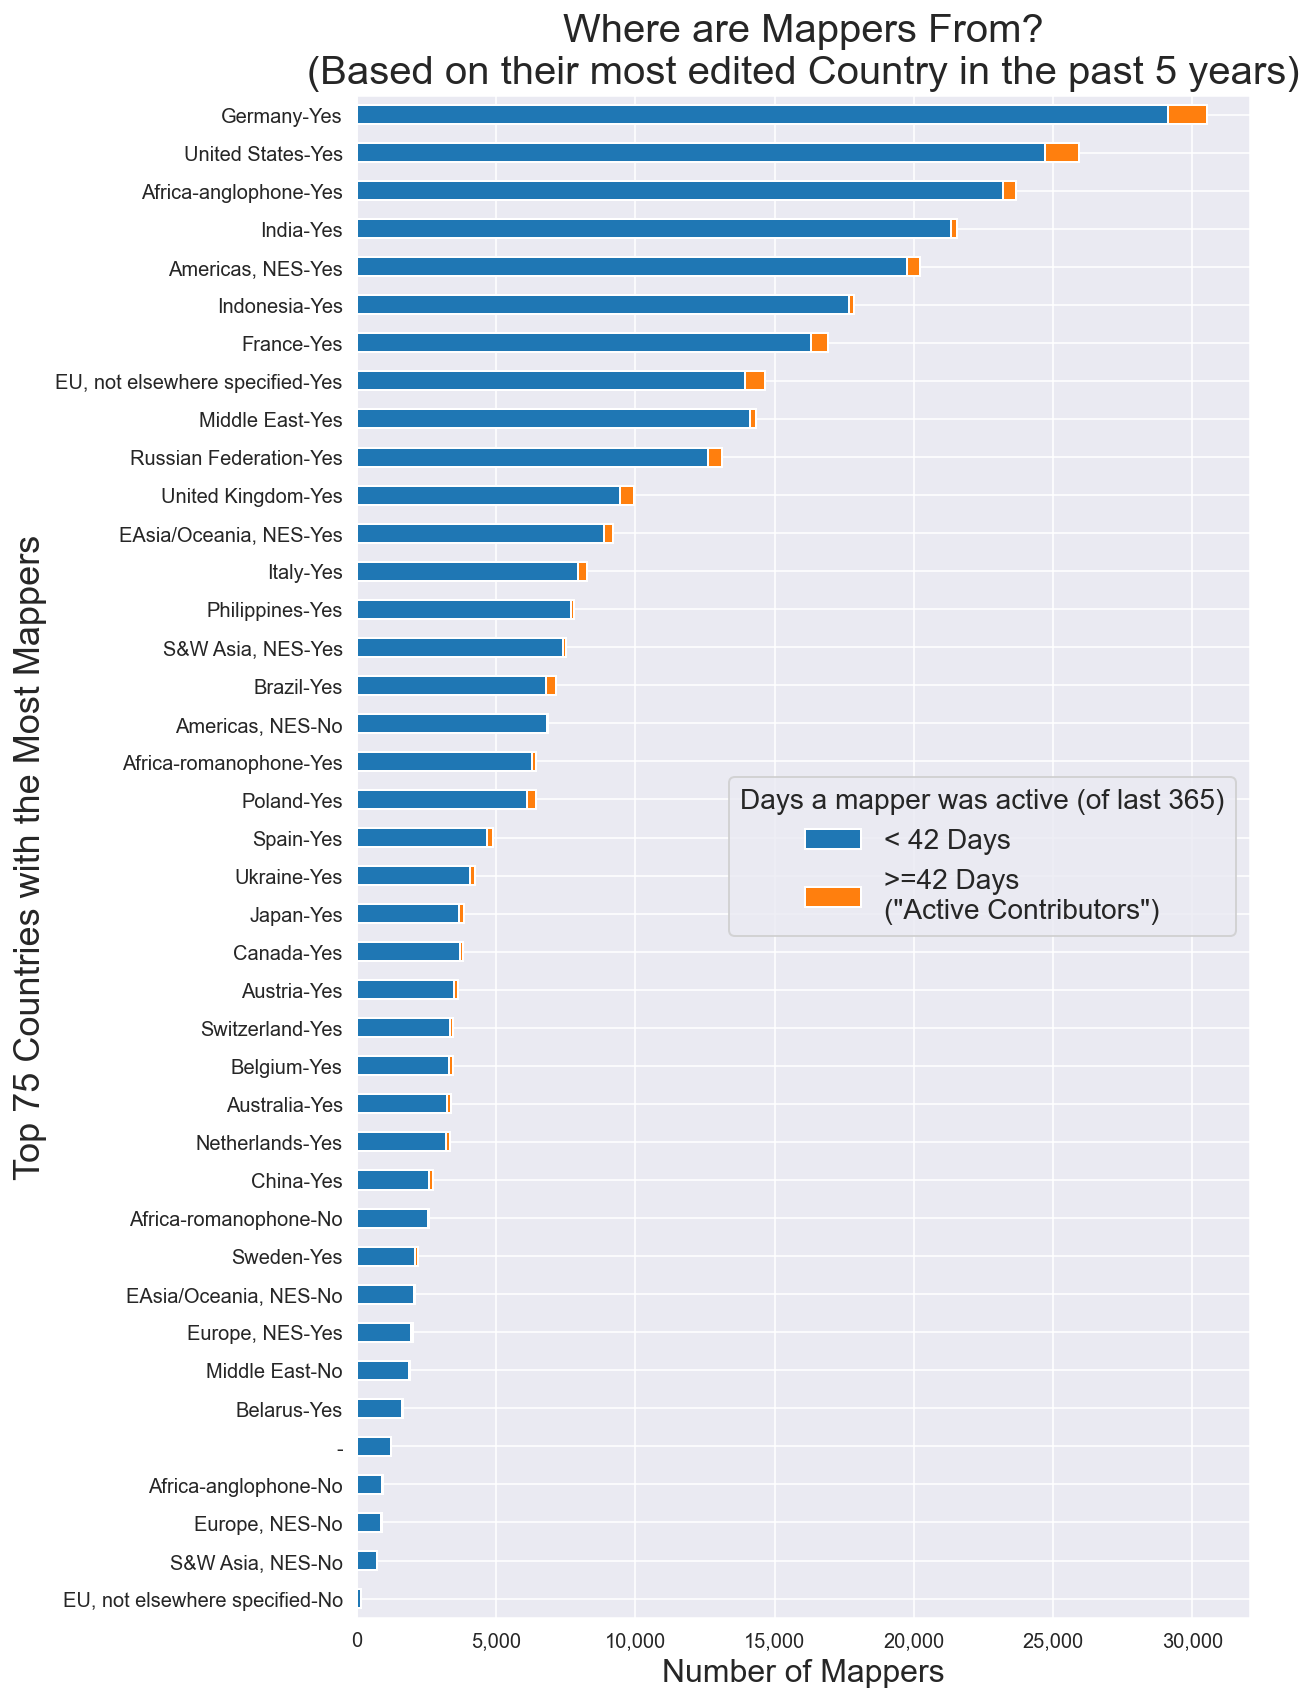

In [22]:
ax = gb_home_country_active.loc[user_order.head(75)]['Users with >= 42 Days'].plot.barh(stacked=True, figsize=(8,14));
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(fontsize=14, loc='center right', title="Days a mapper was active (of last 365)", title_fontsize=14)
ax.invert_yaxis()
ax.set_xlabel("Number of Mappers", fontsize=16); 
ax.set_ylabel("Top 75 Countries with the Most Mappers", fontsize=18);
ax.set_title("Where are Mappers From?\n(Based on their most edited Country in the past 5 years)", fontsize=20);

In [44]:
all_mappers['1']      = all_mappers.editing_days_in_last365.apply(lambda x: x < 2)
all_mappers['2-5']    = all_mappers.editing_days_in_last365.apply(lambda x: x >= 2 and x < 6)
all_mappers['6-19']   = all_mappers.editing_days_in_last365.apply(lambda x: x >= 6 and x < 20)
all_mappers['20-41']  = all_mappers.editing_days_in_last365.apply(lambda x: x >= 20 and x < 41)
all_mappers['42-99'] = all_mappers.editing_days_in_last365.apply(lambda x: x >= 42 and x < 100)
all_mappers['100-199']= all_mappers.editing_days_in_last365.apply(lambda x: x >= 100 and x < 200)
all_mappers['200+']= all_mappers.editing_days_in_last365.apply(lambda x: x >= 200)

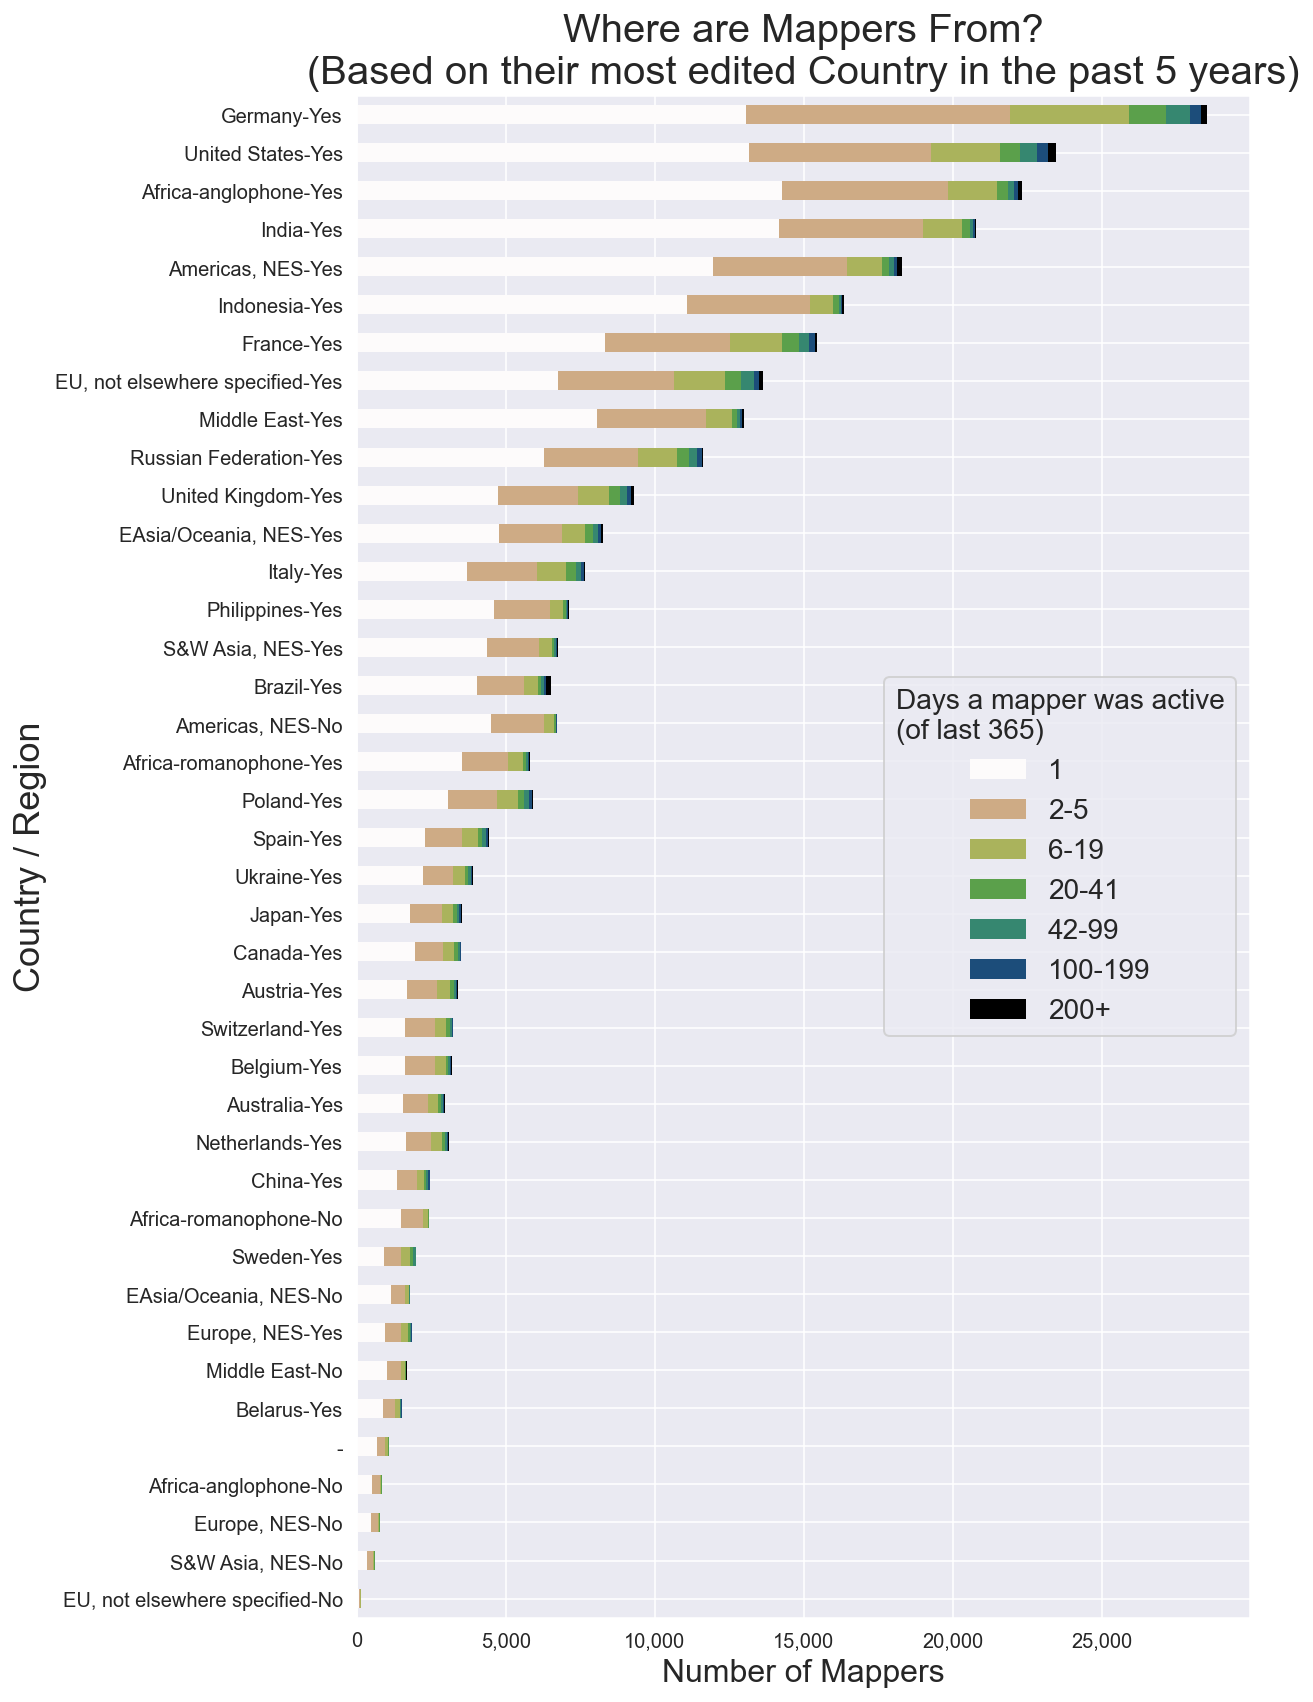

In [45]:
ax = all_mappers.groupby('country').aggregate('sum').loc[user_order.head(100)][
    ['1','2-5','6-19','20-41','42-99','100-199','200+']
].plot.barh(
    stacked=True, figsize=(8,14), cmap=sns.color_palette('gist_earth_r', as_cmap=True), linewidth=0);
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.legend(fontsize=14, loc='center right', title="Days a mapper was active\n(of last 365)", title_fontsize=14)
ax.invert_yaxis()
# ax.legend([])
ax.set_xlabel("Number of Mappers", fontsize=16); 
ax.set_ylabel("Country / Region", fontsize=18);
ax.set_title("Where are Mappers From?\n(Based on their most edited Country in the past 5 years)", fontsize=20);